# Computing the predictions

It's time to see how your net performs on unseen `test` data. We will divide the tutorial in 3 parts depending on whether you want to:
* Predict filepaths contained in a [dataset split .txt file](#Predicting-a-datasplit-txt-file)
* Predict [local images](#Predicting-local-files)
* Predict [url images](#Predicting-image-urls)

**Note** Parameters in UPPERCASE letters must be changed by the user if needed.

### Select False if you want to test on your own data, otherwise use the DEMO data

In [ ]:
DEMO=True

In [110]:
import os
import glob
import json
import numpy as np
import matplotlib.pylab as plt
import yaml
from tensorflow.keras.models import load_model
from planktonclas import paths, config
from planktonclas.data_utils import load_image, load_data_splits, load_class_names ,create_data_splits,load_aphia_ids
from planktonclas.test_utils import predict
from planktonclas import paths, plot_utils, utils
# 2023-06-05_143422
# User parameters to set


TIMESTAMP = 'phytoplankton_vliz'           # timestamp of the model
MODEL_NAME = 'final_model.h5'                           # model to use to make the prediction
TOP_K = 5                                               # number of top classes predictions to save

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load the data
# splits_dir="/srv/phyto-plankton-classification/data/demo-dataset_files"
class_names = load_class_names(splits_dir=paths.get_ts_splits_dir())

# Load training configuration
conf_path = os.path.join(paths.get_conf_dir(), 'conf.json')
with open(conf_path) as f:
    conf = json.load(f)
    
# Load the model
model = load_model(os.path.join(paths.get_checkpoints_dir(), MODEL_NAME), custom_objects=utils.get_custom_objects())

Loading class names...


W0408 15:09:57.888551 140041860499264 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [27]:
conf['general']['images_directory']='data/images_old/'

## Predicting a datasplit txt file

Here we are going to compute the predictions and save them into a `.json` file to retireve them later. 

In [128]:
SPLIT_NAME = 'DS_split_test'                   # dataset split to predict                                      # data split to use
# conf['general']['images_directory'] = '/media/ignacio/Datos/datasets/semillas/datasets/RJB'  # custom the absolute path to the images directory, if needed



conf_path = "/srv/phyto-plankton-classification/etc/demo-config.yaml"
with open(conf_path, 'r') as f:
    CONF = yaml.safe_load(f)

CONF = config.get_conf_dict(CONF)


splits_dir = paths.get_splits_dir()

#if using DEMO
if DEMO:
    splits_dir="/srv/phyto-plankton-classification/data/demo-dataset_files"

if 'train.txt' not in os.listdir(splits_dir ):
    if not (CONF['dataset']['split_ratios']):
        if (CONF['training']['use_validation']) & (CONF['testing']['use_test']):
            split_ratios=[0.7,0.15,0.15]
        elif (CONF['training']['use_validation']) & (~CONF['testing']['use_test']):
            split_ratios=[0.9,0.1,0]
        else:
            split_ratios=[1,0,0]
    else:
        split_ratios=(CONF['dataset']['split_ratios'])
    create_data_splits(splits_dir=splits_dir,
                                    im_dir=CONF['general']['images_directory'],
                                    split_ratios=split_ratios)
        
aphia_ids = load_aphia_ids(splits_dir)


# Load the training data
X_train, y_train = load_data_splits(splits_dir=splits_dir,
                                    im_dir=CONF['general']['images_directory'],
                                    split_name='train')



X_test, y_test = load_data_splits(splits_dir=splits_dir,
                                im_dir=CONF['general']['images_directory'],
                                split_name='test')




# Predict
pred_lab, pred_prob = predict(model, X_test, conf, top_K=TOP_K, filemode='local')


if aphia_ids is not None:
    pred_aphia_ids = [aphia_ids[i] for i in pred_lab]
else:
    pred_aphia_ids= aphia_ids

class_index_map = {index:class_name for index, class_name in enumerate(class_names)}

# Convert arrays of strings to lists of integers
pred_lab = [[class_index_map[label] for label in labels] for labels in pred_lab]
y_test=[class_index_map.get(index) for index in y_test]
# Create the pred_dict as you were doing before
pred_dict = {
    'filenames': list(X_test),
    'pred_lab': pred_lab,
    'pred_prob': pred_prob.tolist(),
    'aphia_ids': pred_aphia_ids,
}
if y_test is not None:
    pred_dict['true_lab'] = y_test



pred_path = os.path.join(paths.get_predictions_dir(), '{}+{}+top{}.json'.format(MODEL_NAME, SPLIT_NAME, TOP_K))
with open(pred_path, 'w') as outfile:
    json.dump(pred_dict, outfile, sort_keys=True)


Loading aphia_ids...
Loading train data...
Loading test data...
8/8 [==============================] - 1s 187ms/step


## Predicting local files

#### Predict a single local image

1/1 [==============================] - 0s 181ms/step


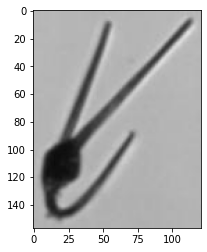

[99.4%] Tripos
[0.6%] Ceratium horridum/C. longipes
[0.0%] Zooplankton
[0.0%] Polychaeta
[0.0%] Cnidaria


In [66]:
FILEPATH = '/srv/phyto-plankton-classification/data/samples/random/Tripos_0B6AD65F-41F6-480B-AB23-2C1A02F992B1_494057.jpg'
pred_lab, pred_prob = predict(model, FILEPATH, conf, top_K=TOP_K, filemode='local')

plt.imshow(load_image(FILEPATH, filemode='local'))
plt.show()
for j in range(pred_lab.shape[1]):
    print('[{:.1f}%] {}'.format(pred_prob[0, j] * 100, class_names[pred_lab[0, j]]))

#### Predict a list of local images

3/3 [==============================] - 0s 139ms/step


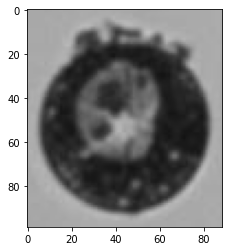

[100.0%] Actinoptychus
[0.0%] Centric Diatom
[0.0%] Actinoptychus senarius
[0.0%] Actinoptychus splendens
[0.0%] Guinardia flaccida


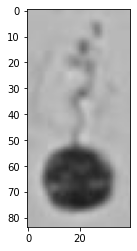

[100.0%] Peritrichia
[0.0%] Ciliophora
[0.0%] Bacillariophyceae
[0.0%] Bubbles
[0.0%] Dinoflagellata


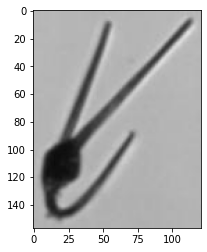

[99.4%] Tripos
[0.6%] Ceratium horridum/C. longipes
[0.0%] Zooplankton
[0.0%] Polychaeta
[0.0%] Cnidaria


In [67]:
FILEPATHS = glob.glob('/srv/phyto-plankton-classification//data/samples/random/*')
     
pred_lab, pred_prob = predict(model, FILEPATHS, conf, top_K=TOP_K, filemode='local')

for i, im_path in enumerate(FILEPATHS):
    plt.figure(i)
    plt.imshow(load_image(im_path, filemode='local'))
    plt.show()
    for j in range(pred_lab.shape[1]):
        print('[{:.1f}%] {}'.format(pred_prob[i, j] * 100, class_names[pred_lab[i, j]]))

#### Predict a list of local images belonging to the same observation

In this case all the images belong to the same observation so we wan to average the predictions among all of them.

In [68]:
FILEPATHS = glob.glob('/srv/phyto-plankton-classification//data/samples/tripos/*')
     
pred_lab, pred_prob = predict(model, FILEPATHS, conf, top_K=TOP_K, filemode='local', merge=True)

for j in range(pred_lab.shape[1]):
    print('[{:.1f}%] {}'.format(pred_prob[0, j] * 100, class_names[pred_lab[0, j]]))

3/3 [==============================] - 0s 157ms/step
[99.8%] Tripos
[0.2%] Ceratium horridum/C. longipes
[0.0%] Zooplankton
[0.0%] Tripos fusus
[0.0%] Polychaeta


## Predicting image urls

#### Predict a single url

1/1 [==============================] - 0s 473ms/step


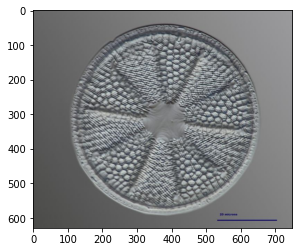

[73.5%] Centric Diatom
[24.9%] Noctiluca scintillans
[0.6%] Actinoptychus splendens
[0.5%] Actinoptychus
[0.3%] Polychaeta


In [69]:
FILEPATH = 'https://forum.mikroscopia.com/uploads/monthly_07_2017/post-2056-0-71322100-1501364951_thumb.jpg'

pred_lab, pred_prob = predict(model, FILEPATH, conf, top_K=TOP_K, filemode='url')

plt.imshow(load_image(FILEPATH, filemode='url'))
plt.show()
for j in range(pred_lab.shape[1]):
    print('[{:.1f}%] {}'.format(pred_prob[0, j] * 100, class_names[pred_lab[0, j]]))

#### Predict a list of urls

2/2 [==============================] - 0s 237ms/step


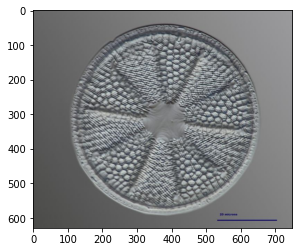

[73.5%] Centric Diatom
[24.9%] Noctiluca scintillans
[0.6%] Actinoptychus splendens
[0.5%] Actinoptychus
[0.3%] Polychaeta


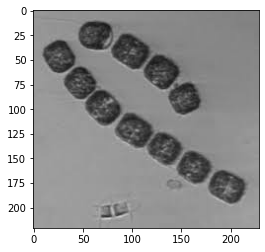

[98.6%] Peritrichia
[1.4%] Thalassiosira/Porosira
[0.0%] Centric Diatom
[0.0%] Stephanopyxis
[0.0%] Ciliophora


In [70]:
FILEPATHS = ['https://forum.mikroscopia.com/uploads/monthly_07_2017/post-2056-0-71322100-1501364951_thumb.jpg',
             'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR4SGFj2dBEobx3eWIo_J7inxK2aWvrQU9KQg&usqp=CAU']

pred_lab, pred_prob = predict(model, FILEPATHS, conf, top_K=TOP_K, filemode='url')

for i, im_path in enumerate(FILEPATHS):
    plt.figure(i)
    plt.imshow(load_image(im_path, filemode='url'))
    plt.show()
    for j in range(pred_lab.shape[1]):
        print('[{:.1f}%] {}'.format(pred_prob[i, j] * 100, class_names[pred_lab[i, j]]))

#### Predict a list of local images belonging to the same observation

In this case all the images belong to the same observation so we wan to average the predictions among all of them.

In [71]:
FILEPATHS = ['https://forum.mikroscopia.com/uploads/monthly_07_2017/post-2056-0-71322100-1501364951_thumb.jpg',
             'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRXaZ8oFlnmkpm7_WpSX9Rj9HluA_m7fPdmlw&usqp=CAU']

pred_lab, pred_prob = predict(model, FILEPATHS, conf, top_K=TOP_K, filemode='url', merge=True)

for j in range(pred_lab.shape[1]):
    print('[{:.1f}%] {}'.format(pred_prob[0, j] * 100, class_names[pred_lab[0, j]]))

2/2 [==============================] - 1s 252ms/step
[55.5%] Centric Diatom
[27.3%] Polychaeta
[12.5%] Noctiluca scintillans
[2.3%] Actinoptychus splendens
[2.2%] Actinoptychus
